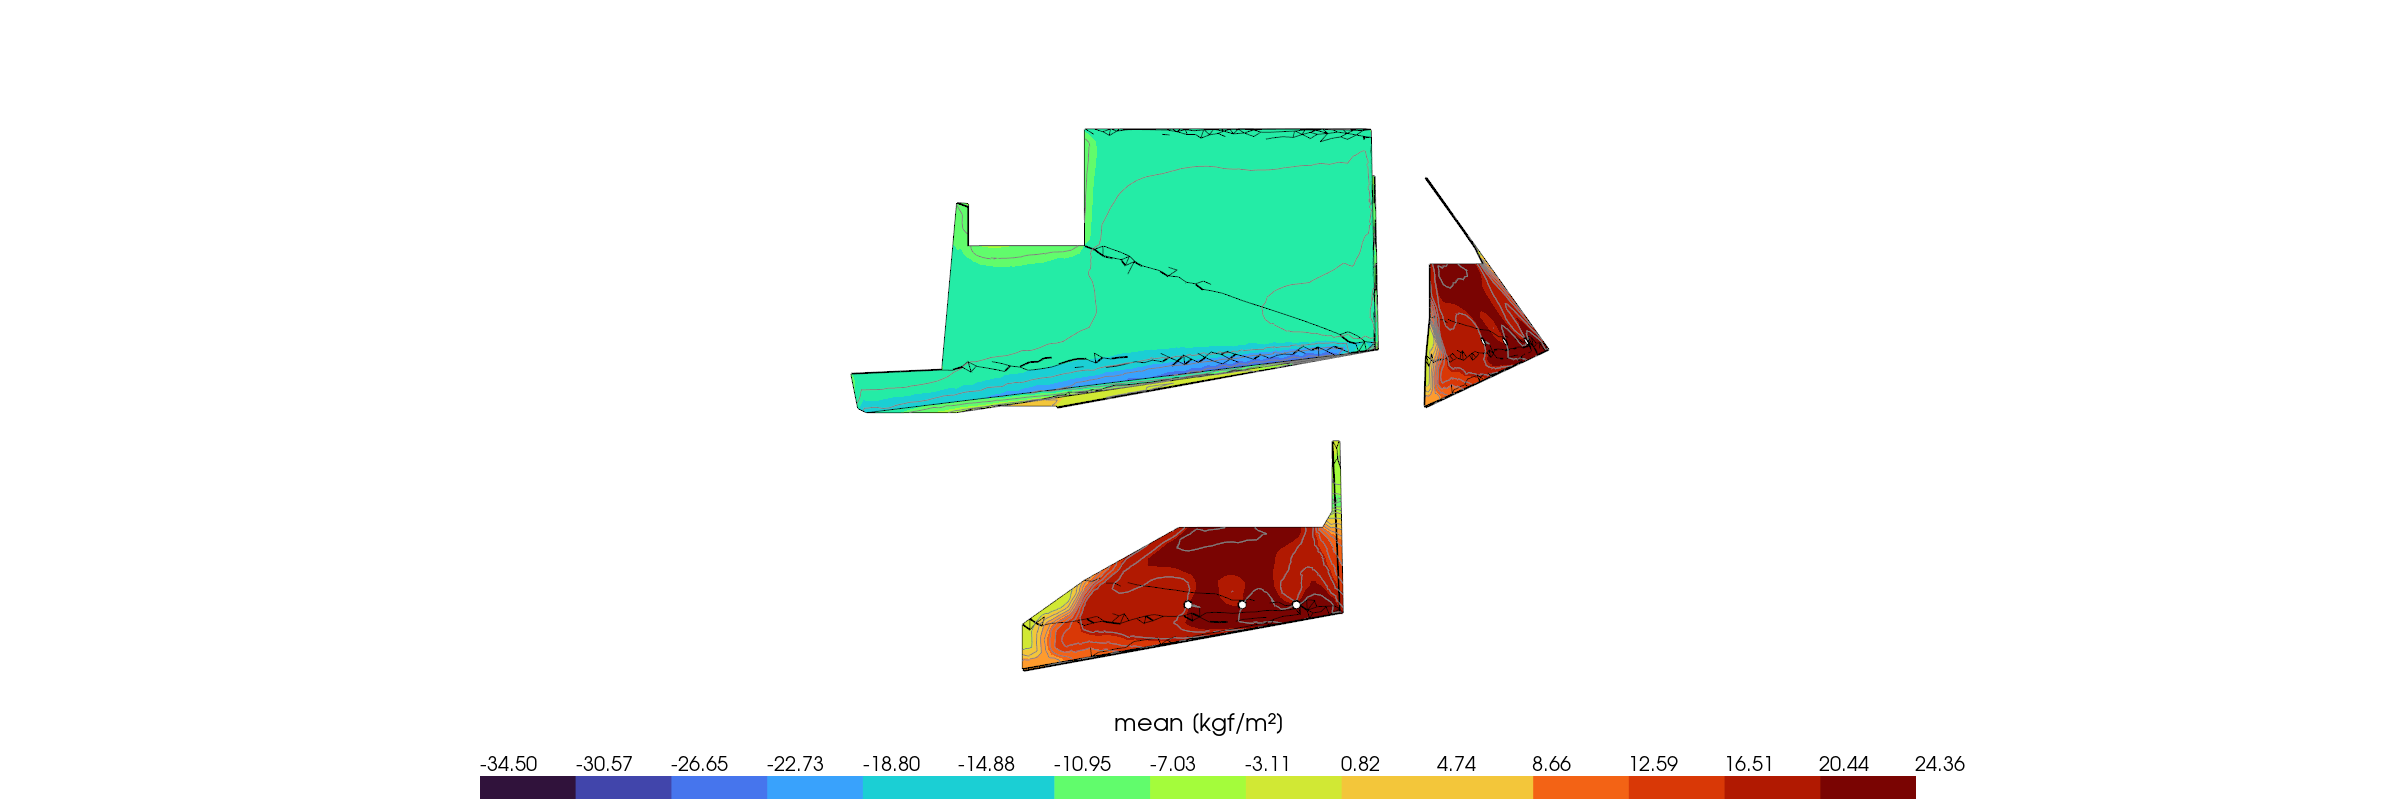

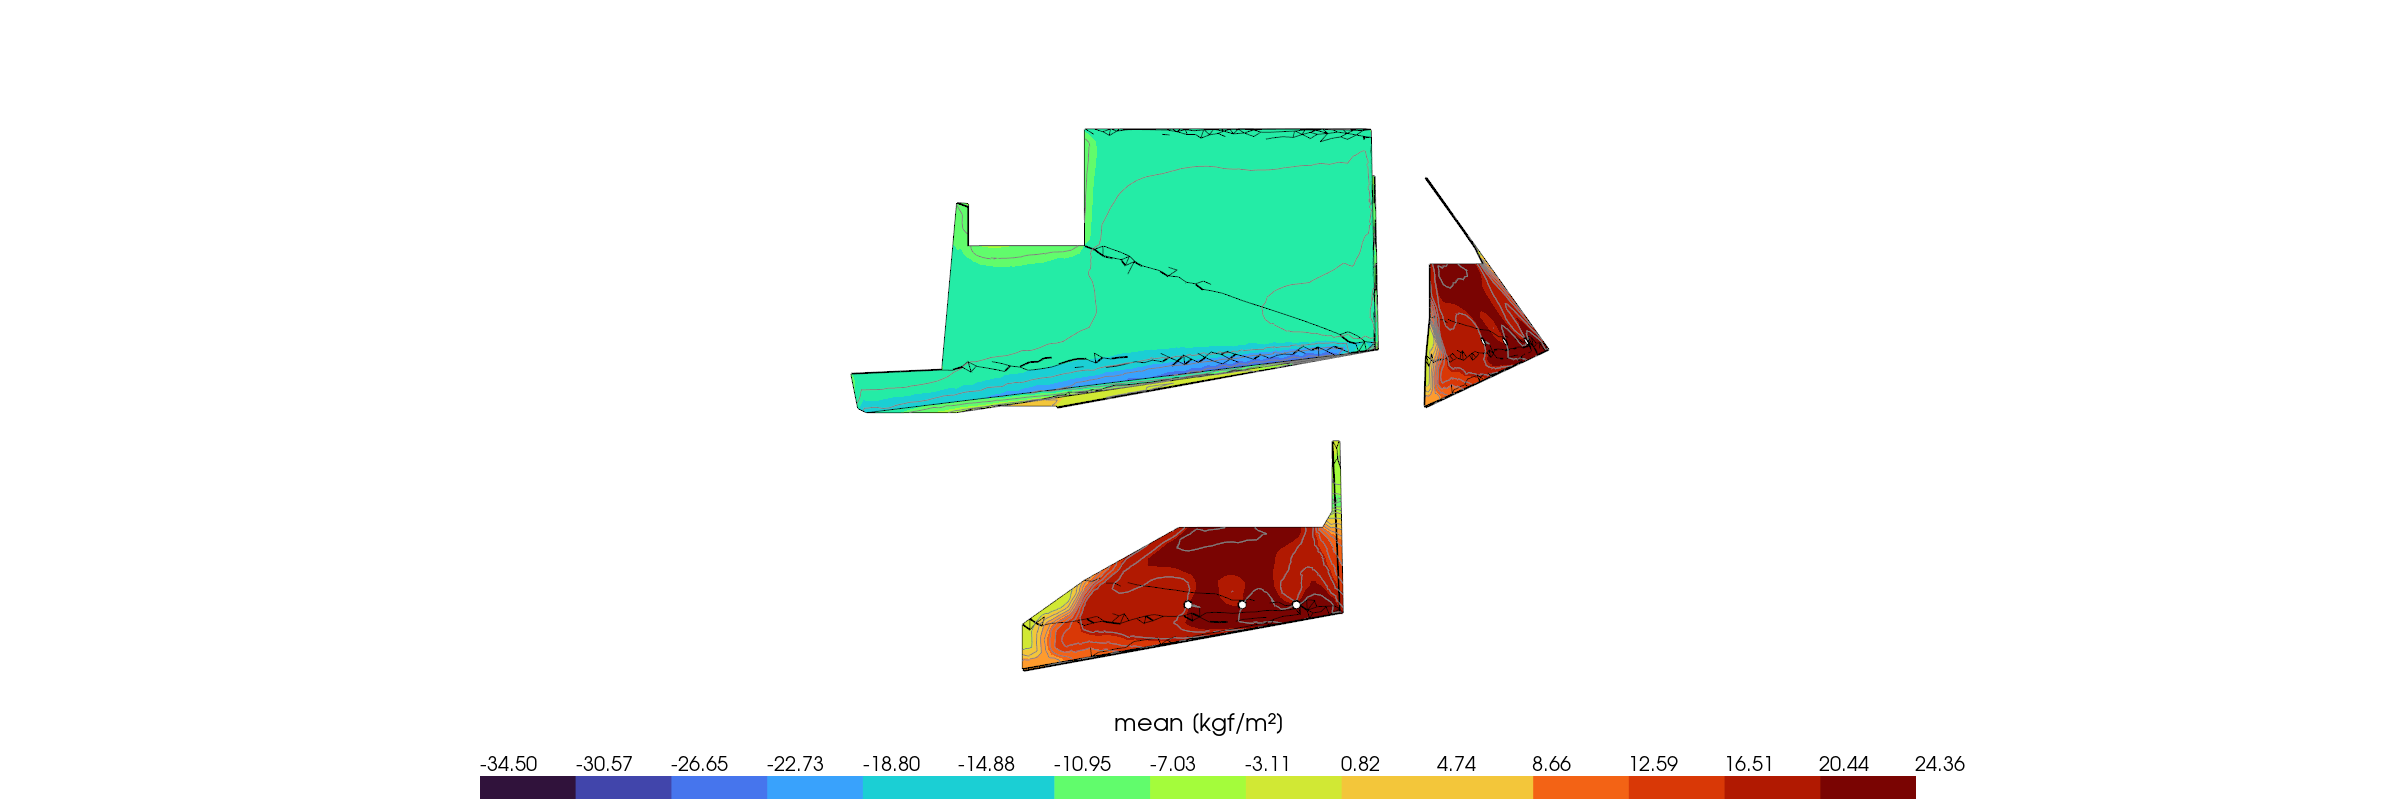

In [ ]:
import pathlib

from cfdmod.use_cases.snapshot.camera import take_snapshot
from cfdmod.use_cases.snapshot.config import SnapshotConfig
from cfdmod.use_cases.snapshot.process_image import process_image
from cfdmod.utils import create_folder_path
import warnings

files_path = pathlib.Path("../fixtures/tests/snapshot")

cfg_path = files_path / "snapshot_params.yaml"
cfg = SnapshotConfig.from_file(cfg_path)

output_path = pathlib.Path("./output/images")
create_folder_path(output_path)

for image in cfg.images:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        take_snapshot(
            scalar_name=image.scalar_label,
            data_source_paths=image.data_source_paths,
            output_path=output_path / f"{image.image_label}.png",
            colormap_params=cfg.colormap,
            projection_params=cfg.projections,
            camera_params=cfg.camera,
        )
    process_image(
        image_path=output_path / f"{image.image_label}.png",
        output_path=output_path / f"{image.image_label}.png",
        crop_cfg=cfg.camera.crop,
    )

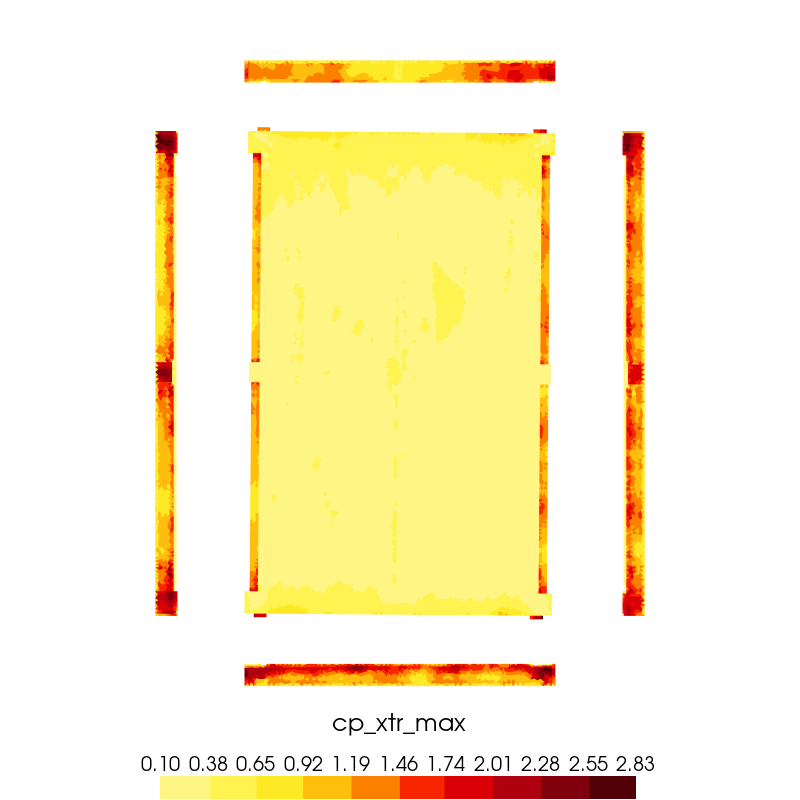

In [ ]:
import pathlib

from cfdmod.use_cases.snapshot.camera import take_snapshot
from cfdmod.use_cases.snapshot.config import SnapshotConfig
from cfdmod.use_cases.snapshot.process_image import process_image
from cfdmod.utils import create_folder_path
import warnings

files_path = pathlib.Path("./fixtures/tests/snapshot")

cfg_path = files_path / "snapshot_params.yaml"
cfg = SnapshotConfig.from_file(cfg_path)

output_path = pathlib.Path("./output/images")
create_folder_path(output_path)

for polydata_cfg in cfg.polydata:
    vtp_path = pathlib.Path(polydata_cfg.file_path)

    for image_cfg in polydata_cfg.images:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            take_snapshot(
                scalar_name=image_cfg.scalar_label,
                file_path=vtp_path,
                output_path=output_path / f"{image_cfg.image_label}.png",
                colormap_params=cfg.colormap,
                projection_params=cfg.projection,
                camera_params=cfg.camera,
            )
        process_image(
            image_path=output_path / f"{image_cfg.image_label}.png",
            output_path=output_path / f"{image_cfg.image_label}.png",
            crop_cfg=cfg.camera.crop,
        )

In [ ]:
from PIL import Image
import pathlib


def paste_watermark(main_image: Image, watermark_image: Image):
    """Adds a watermark to the main image

    Args:
        main_image (Image): Main Image
        watermark_image (Image): Watermark image
    """
    OFFSET = 40
    # position = (main_image.size[0] - watermark_image.size[0] - OFFSET, main_image.size[1] - watermark_image.size[1] - OFFSET)
    position = (OFFSET, OFFSET)
    main_image.paste(
        watermark_image,
        position,
        watermark_image,
    )


images_path = output_path
watermark_path = pathlib.Path("./fixtures/tests/snapshot/dark_logo.png")

watermark_img = Image.open(watermark_path)
w_size = (int(s * 0.2) for s in watermark_img.size)
watermark_img = watermark_img.resize(w_size)

image_prefix = ""

files_list = [f for f in images_path.iterdir() if f.is_file()]
files_list = [f for f in files_list if f.name.startswith(image_prefix)]

for file in files_list:
    t_img = Image.open(file)
    paste_watermark(t_img, watermark_img)
    t_img.save(file.parent / ("watermarked_" + file.name))
    print(file, file.parent / ("watermarked_" + file.name))

output/images/CP_ENVMAX_G100.png output/images/watermarked_CP_ENVMAX_G100.png
